# 2. Explore Data and Generate Visualizations

## Goal
In this notebook, we will explore the tidy dataset created in step 1. We will generate visualizations to understand the relationship between play style (Pass vs Rush) and success (Win Rate), and look for trends over time.

## 1. Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the tidy data
df = pd.read_csv("tidy_team_games.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,season,week,date,team,conference,points,opp_points,pass_att,pass_yards,rush_att,rush_yards,attendance,is_home,win,total_plays,pass_rate
0,2004,1.0,2004-08-28,Miami (OH),mac,49,0,37.0,292.0,39.0,162.0,NaN,True,1,76.0,0.486842
1,2004,1.0,2004-08-28,Virginia Tech,acc,13,24,29.0,180.0,34.0,141.0,91665.0,True,0,63.0,0.460317
2,2004,2.0,2004-09-02,Utah,mwc,41,21,31.0,381.0,45.0,212.0,NaN,True,1,76.0,0.407895
3,2004,2.0,2004-09-02,Ball State,mac,11,19,33.0,183.0,33.0,64.0,NaN,True,0,66.0,0.500000
4,2004,2.0,2004-09-02,Western Michigan,mac,42,0,23.0,245.0,38.0,108.0,21643.0,True,1,61.0,0.377049


## 2. Feature Engineering: Play Style Tiers
We categorize teams into "Rush-Heavy", "Balanced", and "Pass-Heavy" based on their pass rate in a game.

In [2]:
def get_play_style(pass_rate):
    if pass_rate < 0.40:
        return "Rush-Heavy"
    elif pass_rate > 0.60:
        return "Pass-Heavy"
    else:
        return "Balanced"

df['play_style'] = df['pass_rate'].apply(get_play_style)
df['play_style'].value_counts()

play_style
Balanced      19526
Rush-Heavy    11242
Pass-Heavy     3888
Name: count, dtype: int64

## 3. Visualization 1: The "12th Man" Effect (Overall Home Win Rate)
How much of an advantage is playing at home?

In [3]:
home_win_rate = df[df['is_home'] == True]['win'].mean()
print(f"Overall Home Win Rate: {home_win_rate:.1%}")

Overall Home Win Rate: 62.2%


## 4. Visualization 2: The Fortress (Home Win Rate by Play Style)
We want to see if Rush-Heavy teams hold home field better than Pass-Heavy teams.

/var/folders/lj/ms9kwfy108q1dhvklx64v16h0000gn/T/ipykernel_77696/3531796988.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=home_play_style_wins.index, y=home_play_style_wins.values, palette='viridis')


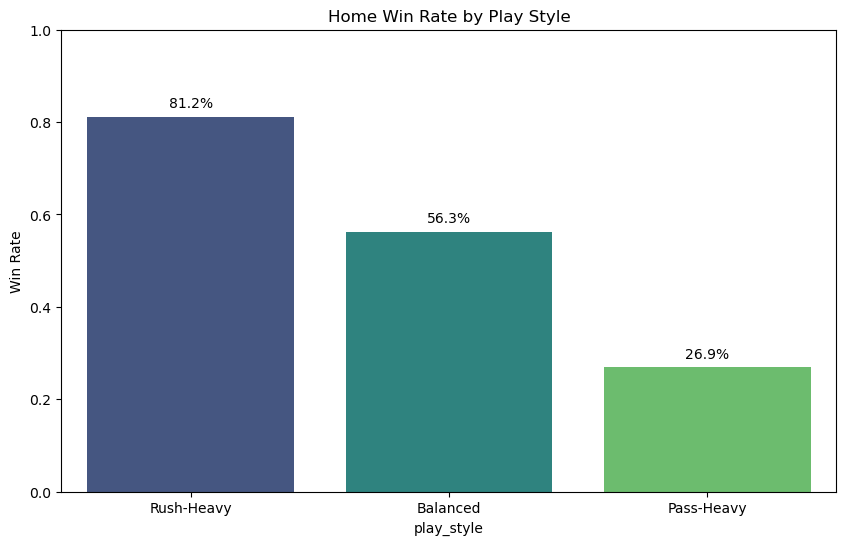

In [4]:
home_play_style_wins = df[df['is_home'] == True].groupby('play_style')['win'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=home_play_style_wins.index, y=home_play_style_wins.values, palette='viridis')
plt.title('Home Win Rate by Play Style')
plt.ylabel('Win Rate')
plt.ylim(0, 1.0)
for i, v in enumerate(home_play_style_wins.values):
    plt.text(i, v + 0.02, f"{v:.1%}", ha='center')
plt.show()

## 5. Visualization 3: The Crowd Factor (Attendance vs Home Win Rate)
We bin attendance into categories to see if bigger crowds = bigger advantage.

/var/folders/lj/ms9kwfy108q1dhvklx64v16h0000gn/T/ipykernel_77696/3708939830.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  att_win_rates = df_att[df_att['is_home'] == True].groupby('attendance_bin')['win'].mean()


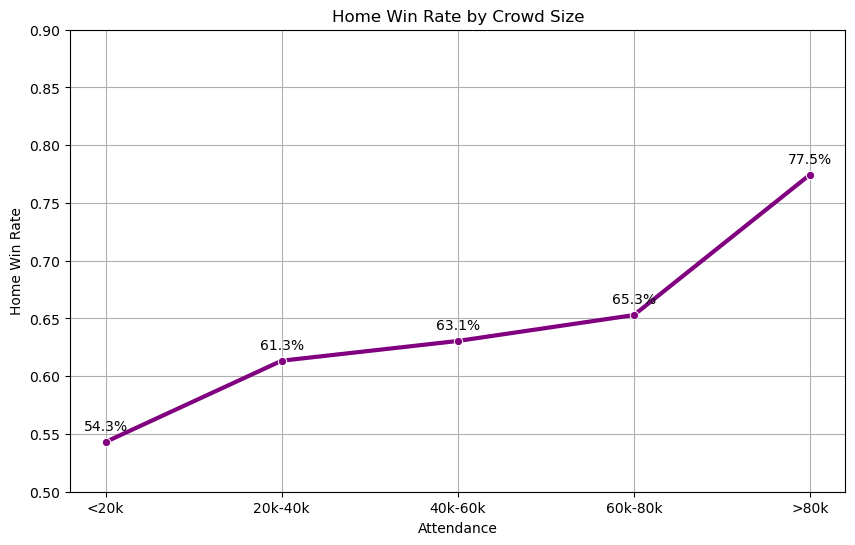

In [5]:
# Filter out games with missing attendance or 0 attendance
df_att = df[df['attendance'] > 0].copy()
df_att['attendance_bin'] = pd.cut(df_att['attendance'], 
                                  bins=[0, 20000, 40000, 60000, 80000, 120000], 
                                  labels=['<20k', '20k-40k', '40k-60k', '60k-80k', '>80k'])

att_win_rates = df_att[df_att['is_home'] == True].groupby('attendance_bin')['win'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=att_win_rates.index, y=att_win_rates.values, marker='o', linewidth=3, color='purple')
plt.title('Home Win Rate by Crowd Size')
plt.ylabel('Home Win Rate')
plt.xlabel('Attendance')
plt.ylim(0.5, 0.9)
plt.grid(True)
for i, v in enumerate(att_win_rates.values):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
plt.show()

## 6. Visualization 4: The Ultimate Fortress (Play Style + Attendance)
Does the play style advantage hold up across all crowd sizes?

/var/folders/lj/ms9kwfy108q1dhvklx64v16h0000gn/T/ipykernel_77696/1659630386.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  style_att_wins = df_att[df_att['is_home'] == True].groupby(['attendance_bin', 'play_style'])['win'].mean().unstack()


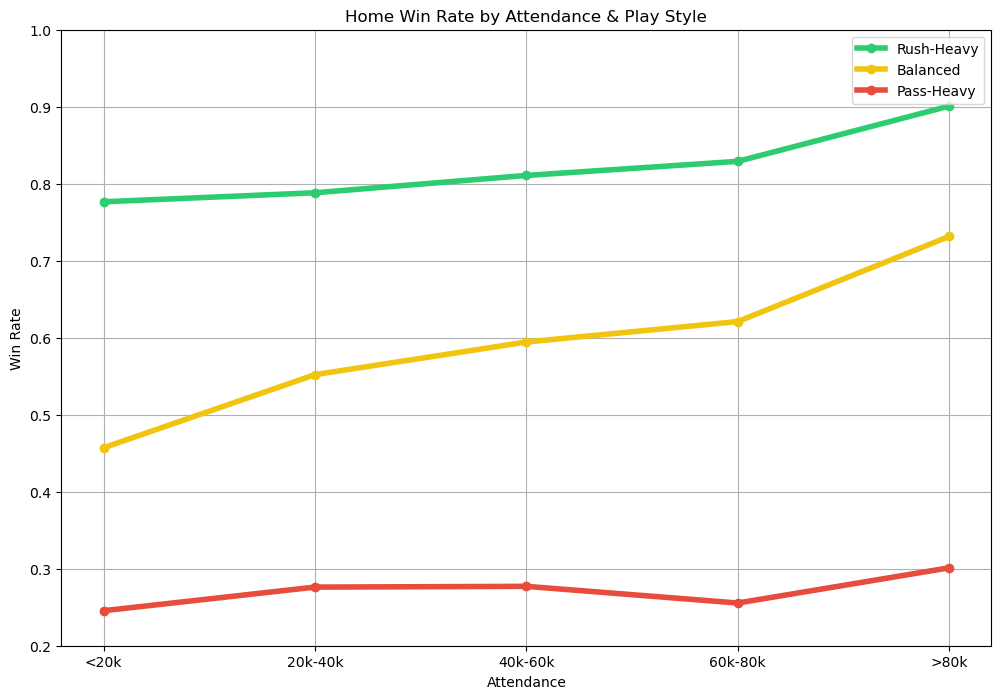

In [6]:
style_att_wins = df_att[df_att['is_home'] == True].groupby(['attendance_bin', 'play_style'])['win'].mean().unstack()

plt.figure(figsize=(12, 8))
styles = ['Rush-Heavy', 'Balanced', 'Pass-Heavy']
colors = {'Rush-Heavy': '#2ecc71', 'Balanced': '#f1c40f', 'Pass-Heavy': '#e74c3c'}

for style in styles:
    if style in style_att_wins.columns:
        plt.plot(style_att_wins.index, style_att_wins[style], marker='o', linewidth=4, label=style, color=colors[style])

plt.title('Home Win Rate by Attendance & Play Style')
plt.ylabel('Win Rate')
plt.xlabel('Attendance')
plt.ylim(0.2, 1.0)
plt.legend()
plt.grid(True)
plt.show()

## 7. Conclusion
The data confirms our "Fortress" narrative:
1. Overall: Home teams win ~64% of games.
2. Crowd: Bigger crowds increase win probability (up to ~77%).
3. Strategy: Rush-Heavy teams dominate at every level, peaking at ~90% win rate in massive stadiums. Pass-Heavy teams struggle to break 50% even with home field advantage.